# 0

Ульянин Дмитрий 597

# 1. Вступление

https://towardsdatascience.com/anime-recommendation-engine-from-matrix-factorization-to-learning-to-rank-845d4a9af335

В статье обсуждается какие бывают алгоритмы, чтобы сделать какой-то движок для рекоммендаций.

**Задача рекоммендаций:** 

Есть набор юзеров $u$, пронумерованных $1..n$, набор итемов $i$ (в данном случае, аниме), пронумерованных $1..m$

Необходимо для юзера уметь получать какой-то топ итемов, которые ему **могут быть интересны**

# 2 Data Pre-processing and Exploration и мое замечение

> There are over 30M observations, 100K users and 6K animation movies in this data set

Из этого можно сделать вывод, что матрица $r_{i,j} = $ оценка юзера $i$ аниме $j$, имеющая размер $100 \cdot 6 \cdot 10^3 \cdot 10^3 = 600 \cdot 10 ^ 6$ -- довольно разряженная, то есть сигнал не очень плотный

(на самом деле это важно, дает много проблем при простроении системы -- алгоритмы не сходятся, матрица плохо обусловлена и т.п.)

# 3 Коллаборативная фильтрация

**Что-то вроде определения** На основе предпочтений других юзеров прогнозировать неизвестные оценки данного юзера

В статье говорится, что очень распространенный способ -- представить пользователей и итемы в качестве эмбеддингов $p_u$, $q_i$ таким образом, что оценка $\hat{r_{u,i}} = <p_u, q_i>$ (скалярное произведение)

_note:_

_На самом деле, это довольно грубо, обычно действуют в предположениях, что у итема и юзера есть еще какие-то смещения, а оценку предстввляют как_ $\hat{r_{u,i}} = <p_u, q_i> + \mu + b_i + b_u$

$\mu$ -- общее смещение оценок, $b_i$ $b_u$ -- индивидуальные смещения пользователей и предметов

_Кажется, это называется Normalization of Global Effects_

## 3.1 Факторизация матриц

Матрица $r$ представляется как факторизация двух матриц $U$ и $P$.

Таким образом $\hat{r_{u, i}}$ равна произведению строки строки $U_{u, *}$ на столбец $P_{*, i}$. То есть мы каждому юзеру и итему сопоставляется эмбеддинг -- строка и столбец соответствующей матрицы, а оценка -- их скалярное произведеие

### 3.1.1 Alternating Least Squares(ALS)

ALS -- это matrix factorisation, осноывнный на линале:

Используем линал (я просто приведу цитату из статьи https://habr.com/company/yandex/blog/241455/ от Мишы Ройзнера)
> Функционал, который мы пытаемся оптимизировать — сумма квадратов ошибок плюс сумма квадратов всех параметров — это тоже квадратичный функционал, он очень похож на параболу.

> Для каждого конкретного параметра, если мы зафиксируем все остальные, это будет как раз параболой. Т.е. минимум по одной координате мы можем точно определить.

>На этом соображении и основан метод Alternating Least Squares. 
В итогн  мы попеременно точно находим минимумы то по одним координатам, то по другим:

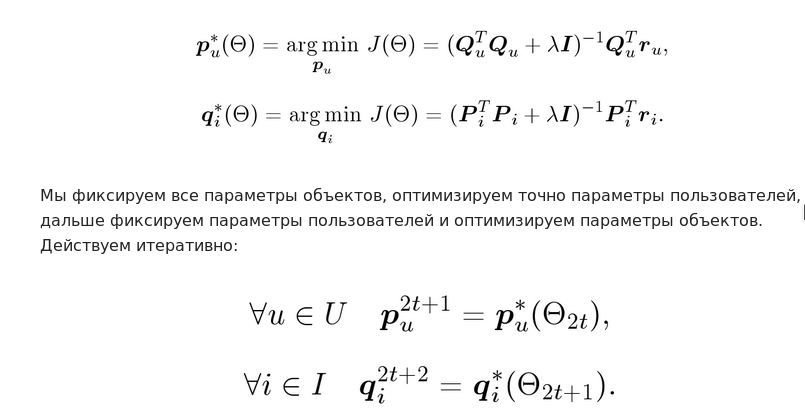

**Юзалась либа pyspark.mllib.recommendation.ALS**

### 3.1.2 SVD (Singular Value Decomposition)

Это все тот же matrix  factorization, но уже юзаем метопты, а именно градиентный спуск (stochastic gradient descent)

**Юзалась либа surprise**

## 3.2 Neural Networks

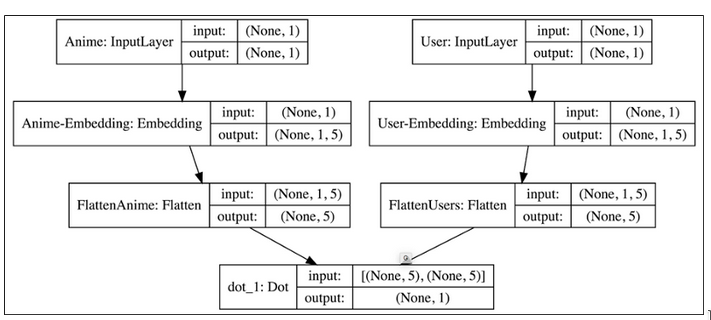

target -- $r_{u,i}$, нейросетка состоит из двух частей, двух слоев.

Вход -- сигналы юзер и item.

Можно условно сказать, что аервый слой учит по эмбеддинги юзеров и item'ов, второй их сворачивает

Таким образом опять же получили два эмбеда, скалярное произведение которых дает оценку

# 4. Обучение ранжированию

Все предыдущие вещи сами по себе не очень жгут и обычно используются просто как майнеры кандидатов при обучении ранжированию.

Почему?

В статье сказано следующее:

Представьте, у нас есть два итема с оценками 3, 4. Один алгоритм дал оценки 2, 5, а другой -- 4. 3. 

С точки зрения MSE алгоритмы одинаково хороши, однако, понятно, что один из алгоритмом переупорядочил результаты, что не очень хорошо.

Дальше в статье просто рассматривались разные метрики и способы построение оценок для этой задачи

## 4.1 Eigen Rank

Здесь метрика не нужна, алгоритм сразу выдает ранжирование

Тут ранжирование строится на том, что у нас уже есть какой-то список ближайшие соседей для ющера -- $N_u$

Дальше, для каждой пары соседей $i, j$ строится preference function (функция предпочтения) $\psi(i, j)$. Затем, все соседи ранжируются жадным алгоритмом на основе $\psi(i, j)$

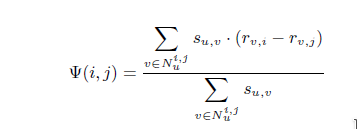


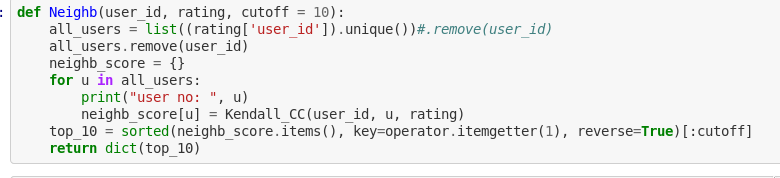

Жадник:

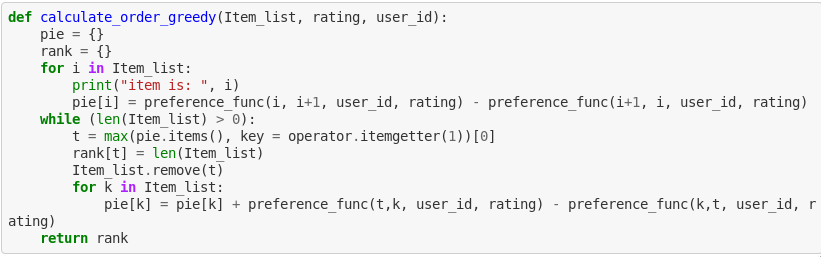

## 4.2 LambdaMART

Оценку строим с помощью градиентного бустинга на решающих деревьях. Признаки в деревьях -- popularity, duration, genres, number of times particular user has watched, release year, ... 

Дальше нужна метрика

## 4.3 Метрики


### 4.3.1 NDCG-Normalized Discounted Cumulative Gain

Предподагаем, что существует идеальное ранжирование (его строим на основе имеющихся рейтингов). А также, что очень релевантные документы (vital) являются более полезными, чем низкорелевантные документы (relevant-).

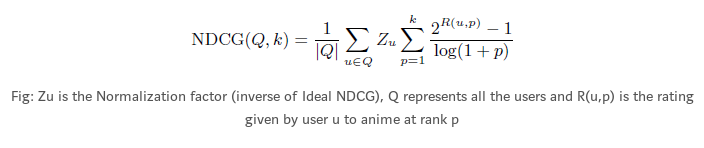

В итоге, NDCG@K -- NDCG, вычисленное для  топ K рекоммендаций по нашему движку

### 4.3.2  MAP -- Mean Average Precision

(почитал так же статью https://habr.com/company/econtenta/blog/303458/)

Пусть AP@K (average precision at K) = $\frac{1}{K} \cdot \sum_{i=1}^K{r(i) \cdot p@i}$,

где $r(i)$ -- оценка топ $i$-го элемента, $p@i$ -- количество релевантных документов среди первых $i$ 

Идея map@K заключается в том, чтобы посчитать ap@K для каждого объекта и усреднить:

Тогда Mean average precision at K (map@K) = $\frac{1}{N} \cdot \sum_{i=1}^K{ap@K_i}$

>Замечание: идея эта вполне логична, если предположить, что все пользователи одинаково нужны и одинаково важны. Если же это не так, то вместо простого усреднения можно использовать взвешенное, домножив ap@K каждого объекта на соответствующий его «важности» вес.


# Заключение

Учитывая, что написано у этих ребят в TODO -- это лишь общие идеи, на чем могут базироваться рекоммендаци и не панацея. В кажом конкретном случае может <<жечь>> что-то свое, в зависимости от специфики области

А с runtime так вообще все плохо -- на python там не попишешь и предсказывать надо за 400 мс, а не за несколько часов